# Practica: Redes convolucionales

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

import numpy as np

In [2]:
#%connect_info
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST

#Definimos el dispositivo que se usara.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

#device = "cpu"

Device:  cuda


In [3]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

# Cifar 10
Es un conjunto de datos que tiene 60,000 imagenes de 32x32 a color de 10 clases distintas (cada clase con 6,000 elementos).
Las clases de este conjunto de datos corresponden a:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, y truck.

Podemos descargar CIFAR-10 con el modulo de torchvision.

In [4]:
#Cargamos los datos de este conjunto en las variables correspondientes al igual que el caso de MNIST
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Para resolver el problema de clasificación de las imágenes de CIFAR-10 usaremos una red neuronal 
cuya arquitectura sea la siguiente:

* Una capa convolucional de entrada con un filtro de (5,5) y 64 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Otra capa convolucional con un filtro de (5,5) y 32 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Una capa completamente conectada con 384 neuronas,cuya activacion es ReLu
* Una capa completamente conectada con 192 neuronas,cuya activacion es ReLu
* Finalmente,una capa de salida con 10 neuronas



In [5]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
import torch.nn.functional as F
class CIFAR_NET(nn.Module):
    def __init__(self):
        '''
        Construccion de la Red, define las capas que se utiizaran.
        '''
        super(CIFAR_NET, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)

        # Conectamos las capas 
        self.fc1 = nn.Linear(32 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)  # 10 clases en CIFAR-10


    def forward(self, x):
        '''
        Define el orden con el que se realizara la propagacion hacia adelante
        de la red.
        '''
        # Capa convolucional 1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Capa convolucional 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Capa conectada 1
        x = x.view(-1, 32 * 5 * 5) # Aplanamos el tensor de la salida de la capa convolucional
        x = F.relu(self.fc1(x))

        # Capa conectada 2
        x = F.relu(self.fc2(x))

        # Capa conectada 3
        x = self.fc3(x)

        return x
    

    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''
        Define una funcion de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza tambien el caso 
        en que se llegue a utilizar cuda. Muestra una grafica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
        # Lista para almacenar las perdidas durante el entrenamiento
        losses = []

        # Si tenemos disponible una GPU, movemos la red a la GPU
        if(cuda and torch.cuda.is_available()):
            self.cuda()
        
        # Iteramos sobre el numero de epocas
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0):
                # Obtenemos los datos y los movemos a la GPU si es necesario
                inputs, labels = data
                if(cuda and torch.cuda.is_available()):
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Reseteamos los gradientes
                optimizer.zero_grad()

                # Propagacion hacia adelante
                outputs = self(inputs)
                loss = criterion(outputs, labels)

                # Propagacion hacia atras y optimizacion
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                # Imprimimos estadisticas
                '''
                if i % 2000 == 1999:  
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
                '''
                '''
                if i % 2000 == 1999:    # Imprimimos cada 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    losses.append(running_loss)
                    running_loss = 0.0
                '''

            # Guardamos la perdida promedio del epoch
            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print('Epoch %d, loss: %.3f' % (epoch + 1, epoch_loss))
        
        # Graficamos las perdidas
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Perdida durante el entrenamiento')
        plt.show()
        


Epoch 1, loss: 1.567
Epoch 2, loss: 1.258
Epoch 3, loss: 1.105
Epoch 4, loss: 1.001
Epoch 5, loss: 0.911
Epoch 6, loss: 0.838
Epoch 7, loss: 0.773
Epoch 8, loss: 0.709
Epoch 9, loss: 0.653
Epoch 10, loss: 0.596
Epoch 11, loss: 0.545
Epoch 12, loss: 0.493
Epoch 13, loss: 0.449
Epoch 14, loss: 0.401
Epoch 15, loss: 0.355
Epoch 16, loss: 0.311
Epoch 17, loss: 0.275
Epoch 18, loss: 0.243
Epoch 19, loss: 0.213
Epoch 20, loss: 0.183
Epoch 21, loss: 0.165
Epoch 22, loss: 0.144
Epoch 23, loss: 0.131
Epoch 24, loss: 0.120
Epoch 25, loss: 0.108
Epoch 26, loss: 0.097
Epoch 27, loss: 0.093
Epoch 28, loss: 0.087
Epoch 29, loss: 0.082
Epoch 30, loss: 0.081


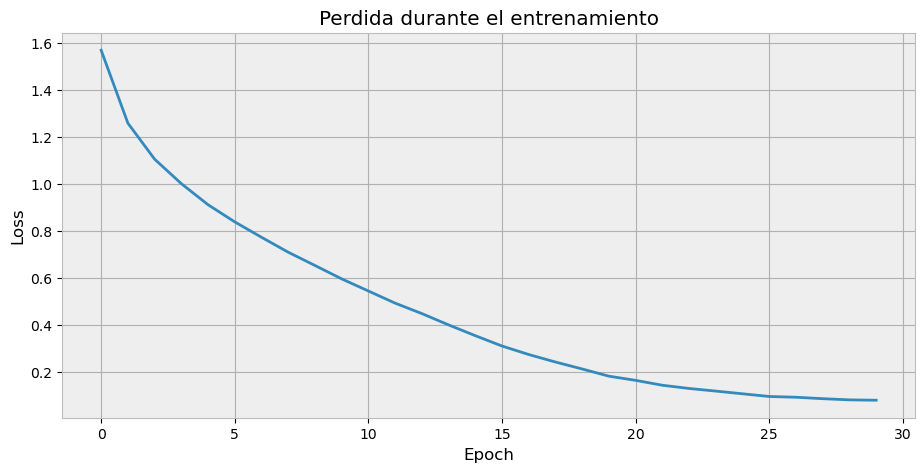

In [6]:
import torch.optim as optim

RedCIFAR=CIFAR_NET()

# Definimos el criterio de perdida (entropia cruzada) y el optimizador (Adam)
criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(RedCIFAR.parameters(), lr=0.0001)

# Preprocesamiento necesario si se va a usar CUDA (GPU)
cuda = True  
if cuda and torch.cuda.is_available(): # Cambia a False si no tenemos una GPU disponible
    RedCIFAR.cuda()

#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR.train(30,trainloader,criterio,optimizer,cuda=cuda) 

In [7]:
# prec_train =calcularPrecisionGlobal(RedCIFAR,trainloader,4)
prec_train = calcularPrecisionGlobal(RedCIFAR, trainloader, 4, cuda=cuda)

# prec_val   =calcularPrecisionGlobal(RedCIFAR,testloader,4)
prec_val = calcularPrecisionGlobal(RedCIFAR, testloader, 4, cuda=cuda)


# print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train),cuda=cuda)
print("Precision en conjunto de entrenamiento: %.4f%%" % prec_train)

#print("Precision en conjunto de validacion: %.4f%%"%(prec_val),cuda=cuda)
print("Precision en conjunto de validacion: %.4f%%" % prec_val)

# Guardamos el modelo
torch.save(RedCIFAR.state_dict(), 'CIFAR10_model.pth')

Precision en conjunto de entrenamiento: 98.4040%
Precision en conjunto de validacion: 69.5100%


## Ejercicios:
* Crea las funciones necesarias para poder introducir datos concretos a la red (una vez ya entrenada) y obtener el resultado que esta devuelve. Muestra la imagen con la que se está alimentando a la red.
* Con la red neuronal entrenada obten la matriz de confusion de ambos conjuntos (entrenamiento y prueba) con las 10 clases posibles. Para ello en lugar de tener en cuenta únicamente los valores de verdaderos positivos, verdaderos negativos, etc, se usarán los 10 elementos, por lo que debemos tener en cuenta cuantos de cada categoria fueron clasificados incorrectamente, y en cual fue.
* Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red.

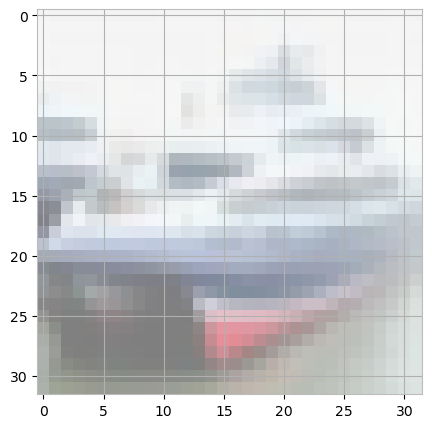

Prediccion: ship
Etiqueta real: ship


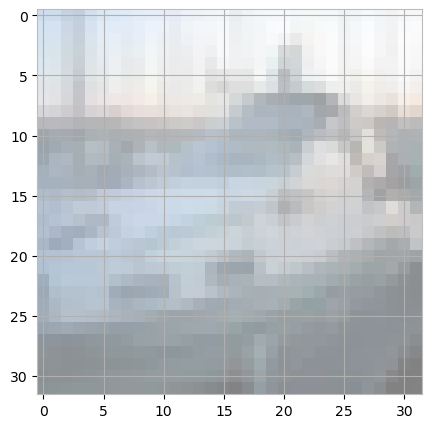

Prediccion: ship
Etiqueta real: ship


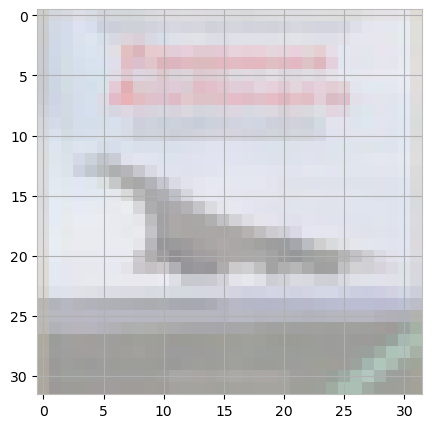

Prediccion: plane
Etiqueta real: plane


In [23]:

def mostrarImagen(image):
    '''
    Muestra una imagen en formato tensor.
    '''
    image = image / 2 + 0.5     # Desnormalizamos
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def predecirImagen(image, net, cuda=False):
    '''
    Dada una imagen, la red y si se va a utilizar CUDA, muestra la imagen y la prediccion de la red.
    '''
    mostrarImagen(image)
    if(cuda and torch.cuda.is_available()):
        image = image.cuda()
    image = Variable(image)
    output = net(image)
    _, predicted = torch.max(output, 1)
    print('Prediccion: %s' % classes[predicted.item()])

# Obtenemos un batch de datos de test
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# Mostramos las imagenes y sus predicciones
#for i in range(4):
#    predecirImagen(images[i], RedCIFAR, cuda=cuda)
#    print('Etiqueta real: %s' % classes[labels[i]])

# Guardamos el modelo
# torch.save(RedCIFAR.state_dict(), 'CIFAR10_model.pth')

# Cargamos el modelo
RedCIFAR = CIFAR_NET()

# Si estamos utilizando CUDA, movemos la red a la GPU
if cuda and torch.cuda.is_available():
    RedCIFAR = RedCIFAR.cuda()

# Cargamos los pesos
RedCIFAR.load_state_dict(torch.load('CIFAR10_model.pth'))



# Mostramos la imagen y sus prediccion
predecirImagen(images[1], RedCIFAR, cuda=cuda)
print('Etiqueta real: %s' % classes[labels[1]])


# Mostramos la imagen y sus prediccion
predecirImagen(images[2], RedCIFAR, cuda=cuda)
print('Etiqueta real: %s' % classes[labels[2]])

# Mostramos la imagen y sus prediccion
predecirImagen(images[3], RedCIFAR, cuda=cuda)
print('Etiqueta real: %s' % classes[labels[3]])





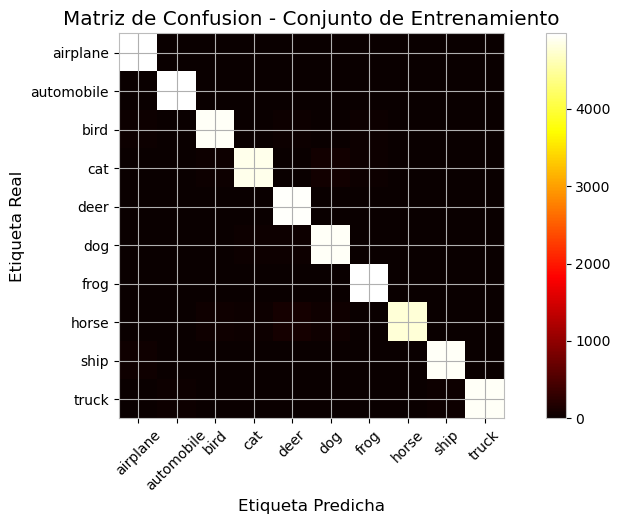

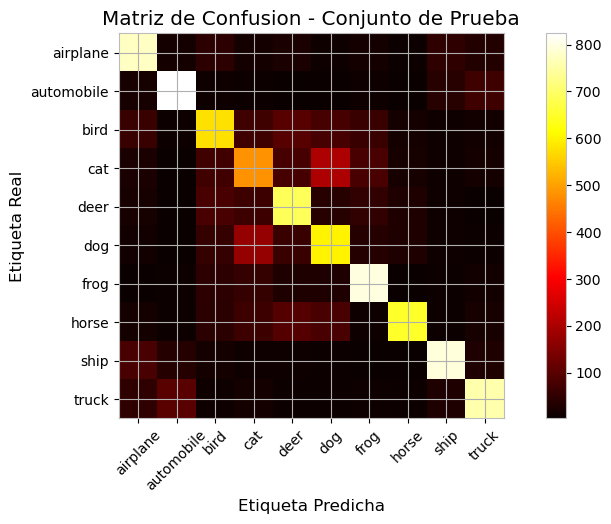

In [36]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def calcularMatrizConfusion(net,data_loader,batch_size,func=None,cuda=False):
    '''
    Calcula la matriz de confusion de una red dada un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario.
    '''
    # Inicializamos la matriz de confusion
    confusion = torch.zeros(10, 10)
    for (images, labels) in data_loader:
        if cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        if func is not None:
            images = func(images)
        salidas = net(images)
        respuestas = salidas.max(dim=1)[1]
        for i in range(len(labels)):
            confusion[labels[i]][respuestas[i]] += 1
    return confusion


# Caluclamos la matriz de confusion de el conjunto de entrenamiento
confusion0 = calcularMatrizConfusion(RedCIFAR, trainloader, 4, cuda=cuda)

# Mostramos la matriz de confusion en formato matriz-tensor
# print(confusion0)

# Mostramos la matriz de confusion de el conjunto de entrenamiento
plt.imshow(confusion0, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(10), classes, rotation=45)
plt.yticks(np.arange(10), classes)
plt.title('Matriz de Confusion - Conjunto de Entrenamiento')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.colorbar() # Barra que muestra el valor de el color
plt.show()


# -------------------------------------------------------------------------------

# Calculamos la matriz de confusion de el conjunto de prueba
confusion = calcularMatrizConfusion(RedCIFAR, testloader, 4, cuda=cuda)

# Mostramos la matriz de confusion en formato matriz-tensor
# print(confusion)

# Mostramos la matriz de confusion de el conjunto de prueba
plt.imshow(confusion, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(10), classes, rotation=45)
plt.yticks(np.arange(10), classes)
plt.title('Matriz de Confusion - Conjunto de Prueba')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.colorbar() # Barra que muestra el valor de el color
plt.show()




### **Conclusiones** 

Como podemos notar, en la matriz de confusion de el entrenamiento/prueba, pudimos visualizar mejor los resultados obtenidos en la precision de el modelo, notese como es que en la parte de entrenamiento el modelo pudo predecir con una buena efectividad del 98.4040% las imagenes y sus clases, sin embargo en la parte de prueba, el modelo no tuvo un rendimiento tan bueno como el anterior, ya que solo pudo predecir con una efectividad del 
69.5100% las imagenes y sus clases, sin emabrgo en este ultimo podemos notar algo curioso, en la parte de los camiones (trucks) la red clasifico la mayor parte como camiones pero otra parte la clasifico como automoviles (automobile), lo cual es hasta cierto punto logico por el parecido entre carros y camiones (esto tambien pasa con los demas vehiculos pero en menor medida), algo similar tambien pasa con los animales, ya que al tener bastantes caracteristicas en comun (en especial los perros y los gatos), la red predijo un buen numero de estos en clases que no les correspondian, sin embargo, en general, el modelo tuvo un rendimiento aceptable en la clasificacion de las imagenes de CIFAR-10, ya que si bien tuvimos cosas como las anteriores, notese como es que nuestro modelo no confundio a cualquier tipo de vehiculo con un animal o viceversa, lo cual es un buen indicativo de que el modelo esta aprendiendo correctamente las caracteristicas de las imagenes y que probablemente con mas entrenamiento o ajustes podriamos mejorar su rendimiento.


[![](https://media1.tenor.com/m/Jc9jT66AJRwAAAAd/chipi-chipi-chapa-chapa.gif)](https://www.youtube.com/watch?v=dQw4w9WgXcQ)


Referencias:

* Krizhevsky , Nair , Hinton. CIFAR-10. https://www.cs.toronto.edu/~kriz/cifar.html
* Pytorch, TORCH.NN, https://pytorch.org/docs/stable/nn.html
* Goodfellow-et-al. (2016). Deep Learning. MIT Press. https://www.deeplearningbook.org/contents/convnets.html

In [37]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()